### KNN Regression Model with RF + RFECV Feature Selection

In [1]:
import re
import os
import joblib
import argparse
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Check current workspace
os.getcwd()

'/home/rc/capstone/notebooks/model-train-tests'

In [2]:
# Define output directory
out_dir = Path("../../submissions/knn") 

# Set cwd for workspace (load knn model framework) and knn model outputs
# os.chdir('../../knn_test')

# Load the serialized objects (verify framework paths for loading in the model)
final_model = joblib.load(out_dir / 'knn_final_model.joblib')
preprocessor = joblib.load(out_dir / 'preprocessor.joblib')
selector = joblib.load(out_dir / 'rfecv_selector.joblib')

In [3]:
# set file paths
os.chdir('../../data')

# Load new data
df_new = pd.read_csv("Key_indicator_districtwise.csv")

# Features prefix cleaning:
# os.chdir('../knn_test/test')

# Define your ID columns and target
id_cols = ['State_Name', 'State_District_Name'] 
target_col = 'YY_Infant_Mortality_Rate_Imr_Total_Person'           

# Remove prefix feature column names
#df_new.columns = [re.sub(r'^[A-Z]{2}_', '', col) for col in df_new.columns]
#id_cols_fixed = [re.sub(r'^[A-Z]{2}_', '', col) for col in id_cols]

# Drop ID columns and target if present
drop_cols = id_cols + ([target_col] if target_col in df_new.columns else [])
X_new = df_new.drop(columns=drop_cols, errors='ignore')

# Apply preprocessor
X_new_processed = preprocessor.transform(X_new)

# Apply feature selector
X_new_selected = selector.transform(X_new_processed)

# Predict with final model
y_new_pred = final_model.predict(X_new_selected)

/home/rc/capstone/venv/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['LL_Total_Fertility_Rate_Rural' 'LL_Total_Fertility_Rate_Urban']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [ ]:
# test knn predictions
print(y_new_pred)

In [4]:
# Check numpy array dimensions
y_new_pred.shape

(284,)

In [5]:
os.getcwd()

'/home/rc/capstone/data'

In [6]:
os.chdir('../submissions/knn')

In [7]:
# If working with new batch prediction
# y_test: true labels for test set
# y_pred: predictions from model

# Load in knn model train/test pipeline
X_train_selected = np.load('X_train_selected.npy')
X_test_selected = np.load('X_test_selected.npy')
y_train_selected = np.load('y_train_pred.npy')
y_test_pred = np.load('y_test_pred.npy')

y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_pred = np.load('y_pred.npy')

if target_col in df_new.columns:
    y_test = df_new[target_col].values 
else:
    y_test = None  

# Test knn regression model predictions:
y_pred = final_model.predict(X_new_selected)
if y_test is not None:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    n = len(y_test)
    p = X_new_selected.shape[1]
    adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1) if n > p + 1 else None
else:
    print("No ground truth values found for evaluation.")

In [8]:
r2

0.9965852154865098

In [9]:
mae

0.2749370968902683

In [10]:
adj_r2

0.9964730510316872

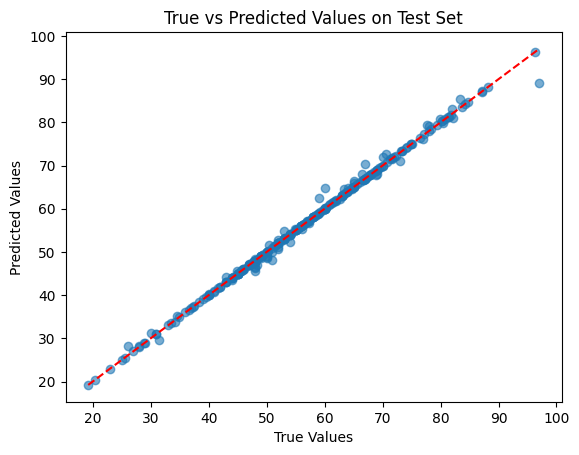

In [11]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values on Test Set')
plt.show()

In [16]:
print("y_test shape:", y_test.shape)
print("y_test_pred shape:", y_test_pred.shape)

y_test shape: (284,)
y_test_pred shape: (71,)


In [19]:
print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train_selected shape: (213, 9)
X_test_selected shape: (71, 9)
y_train shape: (213,)
y_test shape: (284,)


In [ ]:
y_test_subset = y_test[selected_indices]  # subset of true labels matching selected test features

# Now shapes align:
print(y_test_subset.shape)  # should be (71,)
print(y_test_pred.shape)    # should be (71,)

# Compute metrics safely
print("R2:", r2_score(y_test_subset, y_test_pred))

In [ ]:
# Training metrics
y_train_pred = final_model.predict(X_train_selected)
n_tr = len(y_train)
p_tr = X_train_selected.shape[1]
train_metrics = {
    'R2': r2_score(y_train, y_train_pred),
    'Adjusted R2': 1 - (1 - r2_score(y_train, y_train_pred)) * (n_tr - 1) / (n_tr - p_tr - 1) if n_tr > p_tr + 1 else None,
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'MAE': mean_absolute_error(y_train, y_train_pred)
}

# Test metrics
y_test_pred = final_model.predict(X_test_selected)
n_te = len(y_test)
p_te = X_test_selected.shape[1]
test_metrics = {
    'R2': r2_score(y_test, y_test_pred),
    'Adjusted R2': 1 - (1 - r2_score(y_test, y_test_pred)) * (n_te - 1) / (n_te - p_te - 1) if n_te > p_te + 1 else None,
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'MAE': mean_absolute_error(y_test, y_test_pred)
}

In [ ]:
# Save model performance metrics
with open('metrics.txt', 'w') as f:
    json.dump(metrics, f)

In [ ]:
# Training set
plot_true_vs_pred(y_train, y_train_pred, out_dir, 'Training', train_metrics)

In [ ]:
# Test set
plot_true_vs_pred(y_test, y_test_pred, out_dir, 'Testing', test_metrics)

/home/rc/capstone/venv/lib/python3.12/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['LL_Total_Fertility_Rate_Rural' 'LL_Total_Fertility_Rate_Urban']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Text(0, 0.5, 'Importance')

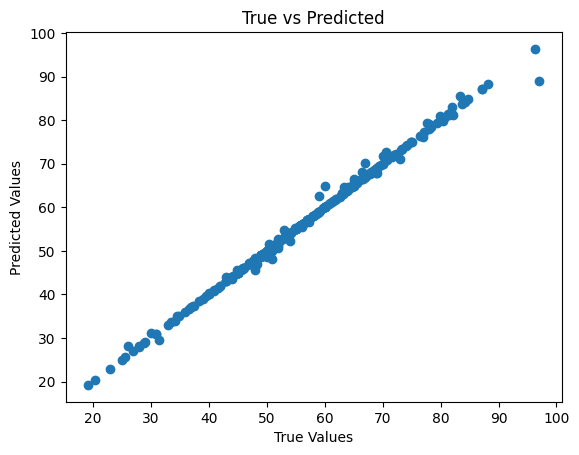

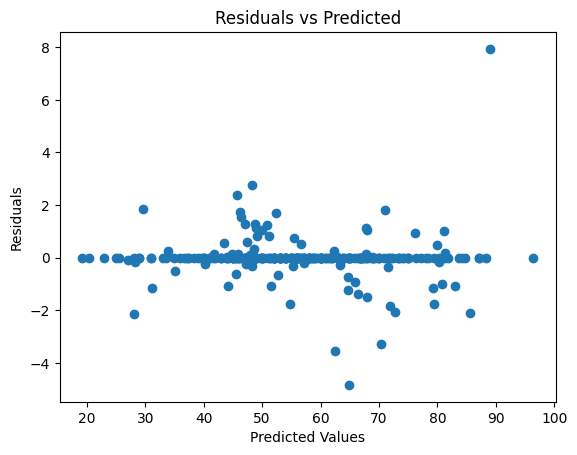

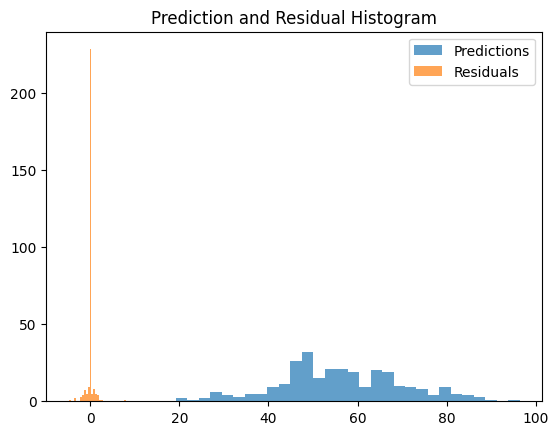

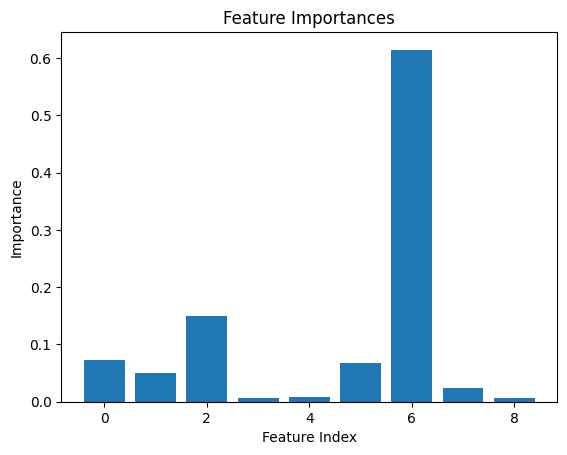

In [15]:
# Preprocessing and prediction
X_new_processed = preprocessor.transform(X_new)
X_new_selected = selector.transform(X_new_processed)
y_pred = final_model.predict(X_new_selected)

# True-predicted scatter
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Values"); plt.ylabel("Predicted Values")
plt.title("True vs Predicted")

# Residual plot
residuals = y_test - y_pred
plt.figure()
plt.scatter(y_pred, residuals)
plt.xlabel("Predicted Values"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")

# Histogram
plt.figure()
plt.hist(y_pred, bins=30, alpha=0.7, label='Predictions')
plt.hist(residuals, bins=30, alpha=0.7, label='Residuals')
plt.legend()
plt.title("Prediction and Residual Histogram")

# Feature importances (if selector uses tree-based model)
importances = selector.estimator_.feature_importances_
plt.figure()
plt.bar(range(len(importances)), importances)
plt.title("Feature Importances")
plt.xlabel("Feature Index"); plt.ylabel("Importance")

In [21]:
import numpy as np
import joblib

X_test_selected = np.load('X_test_selected.npy')
y_test = np.load('y_test.npy')
y_test_pred = np.load('y_test_pred.npy')

X_train_selected = np.load('X_train_selected.npy')
y_train = np.load('y_train.npy')
y_train_pred = np.load('y_train_pred.npy')

model = joblib.load('knn_final_model.joblib')
preprocessor = joblib.load('preprocessor.joblib')
selector = joblib.load('rfecv_selector.joblib')

In [22]:
print("X_test_selected shape:", X_test_selected.shape)
print("y_test shape:", y_test.shape)
print("y_test_pred shape:", y_test_pred.shape)

X_test_selected shape: (71, 9)
y_test shape: (71,)
y_test_pred shape: (71,)


In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

r2 = r2_score(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
#rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)

print(f"R2: {r2}, RMSE: {rmse}, MAE: {mae}")

R2: 0.988711448362954, RMSE: 1.644339228349044, MAE: 1.0997483875610736
